In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import randint
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
import time
import plotly
import warnings
warnings.filterwarnings('ignore')

In [50]:
bdif = pd.read_excel("bdif_modelo_2017.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


### Aplicamos mapeo de clases a la variable objetivo

In [51]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    339190
1    237218
2      2008
Name: count, dtype: int64

In [52]:
# Separamos el dataset para usarlo para el entrenamiento del modelo
bdif_modelo = bdif[bdif['año'] <= 2016]
bdif_modelo.shape

(570372, 30)

In [53]:
bdif_modelo.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,1
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,0
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,0
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,1
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,0


### Preprocesamiento de los datos

In [54]:
# Seleccionamos las variables numéricas y categóricas 
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Aplicamos las transformaciones para cada tipo de variable
prep = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False), categoricas),])

# Creamos el pipeline
pipeline = Pipeline(steps=[('prep', prep)])

# Introducimos los datos de entrada
X = bdif_modelo.drop(columns=['claseincendio'])

# Ajustar el Pipeline a los datos y transformar
X_prep = pipeline.fit_transform(X)

# Lo pasamos a dataframe
X_prepdf = pd.DataFrame(X_prep, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_prepdf.filter(regex='^cat').columns
X_prepdf[dummies] = X_prepdf[dummies].astype(int)

# Eliminamos los prefijos
X_prepdf.columns = X_prepdf.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Reconstruimos el dataset y lo mostramos
X_prepdf['claseincendio'] = bdif_modelo['claseincendio']
bdif_reconstruido = X_prepdf.copy()
bdif_reconstruido.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,1,0,0,0,0,1,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,1,0,0,1,0,0,0,0,1,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,0,0,0,1,0,0,1,0,0,0


In [55]:
# Tomamos el dataset con las caracteristicas que nos interesan
bdif_reconstruido = bdif_reconstruido[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]

In [56]:
bdif_reconstruido.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.000014,0.462795,0.000166,0.703490,0.663822,1,0.068724,0.541667,0.517710,0,...,0,0,1,0,0,0,0,1,0,1
1,0.000006,0.637024,0.001347,0.731106,0.672918,1,0.421203,0.510417,0.335891,0,...,0,0,1,1,0,0,0,1,0,0
2,0.000018,0.571688,0.000341,0.760152,0.707177,1,0.067092,0.697917,0.351240,0,...,0,0,0,0,0,0,0,1,1,0
3,0.000145,0.662432,0.000563,0.699029,0.672143,1,0.256033,0.614583,0.664109,0,...,1,0,1,0,1,0,0,1,0,1
4,0.000076,0.575318,0.000141,0.714636,0.675420,1,0.089480,0.427083,0.410272,0,...,0,0,0,0,0,0,0,0,1,0


### Submuestreo con Edited Nearest Neighbors (ENN) + Tomek Links

In [57]:
# Cargamos el conjunto de datos submuestreado 
bdif_enn_tomek = pd.read_excel("bdif_submuestreado.xlsx")
bdif_enn_tomek.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.014306,0.618875,0.000183,0.559100,0.802846,0,0.265486,0.572917,0.543093,1,...,0,0,0,0,0,1,0,0,0,0
1,0.000358,0.542650,0.000068,0.523174,0.647512,0,0.000000,0.656250,0.418536,1,...,0,1,1,0,0,1,1,0,0,0
2,0.000269,0.802178,0.000060,0.574670,0.718691,0,0.378725,0.427083,0.236128,1,...,0,0,0,0,0,0,0,0,0,0
3,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0


In [58]:
bdif_enn_tomek['claseincendio'].value_counts()

claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64

### Función de reducción de muestras

In [73]:
X = bdif_enn_tomek.drop(['claseincendio'], axis=1) 
y = bdif_enn_tomek['claseincendio'] 

# {0:int(1.5*y.value_counts()[2]), 1:int(1.5*y.value_counts()[2])}
# {0:int(y.value_counts()[1])}
# {0:int(0.5*y.value_counts()[1]), 1:int(0.5*y.value_counts()[1])}
# {0:int(0.25*y.value_counts()[1]), 1:int(0.25*y.value_counts()[1])}
# {0:int(0.12*y.value_counts()[1]), 1:int(0.12*y.value_counts()[1])}
rus = RandomUnderSampler(sampling_strategy={0:int(0.12*y.value_counts()[1]), 1:int(0.12*y.value_counts()[1])}, random_state=42)
#rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
0    3141
1    3141
2    1966
Name: count, dtype: int64


### Hacemos el sobremuestreo con SMOTE

In [43]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de SMOTE: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de SMOTE: Counter({0: 2516, 1: 2516, 2: 2516})
Distribución de clases en el conjunto de test: Counter({0: 636, 1: 625, 2: 389})


### Hacemos el sobremuestreo con ADASYN

In [47]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

adasyn = ADASYN(sampling_strategy={2: int(1.25*y.value_counts()[2])}, random_state=42)
X_train, y_train = adasyn.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de ADASYN: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de ADASYN: Counter({1: 2513, 0: 2512, 2: 2364})
Distribución de clases en el conjunto de test: Counter({0: 629, 1: 628, 2: 393})


### Hacemos el sobremuestreo con BorderlineSMOTE

In [12]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = borderline_smote.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de Borderline-SMOTE: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de Borderline-SMOTE: Counter({1: 2513, 0: 2513, 2: 2513})
Distribución de clases en el conjunto de test: Counter({0: 629, 1: 628, 2: 393})


### Hacemos el sobremuestreo con RandomOverSampler

In [74]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = random_oversampler.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de Random Over-Sampling: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de Random Over-Sampling: Counter({1: 2513, 0: 2513, 2: 2513})
Distribución de clases en el conjunto de test: Counter({0: 629, 1: 628, 2: 393})


### Entrenamos un Random Forest

In [75]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

# Partimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [76]:
# Entrenamos
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [77]:
# Hacemos las predicciones
y_pred = rf.predict(X_test)

# Evaluamos el modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       629
           1       0.84      0.84      0.84       628
           2       0.77      0.74      0.75       393

    accuracy                           0.85      1650
   macro avg       0.84      0.84      0.84      1650
weighted avg       0.85      0.85      0.85      1650



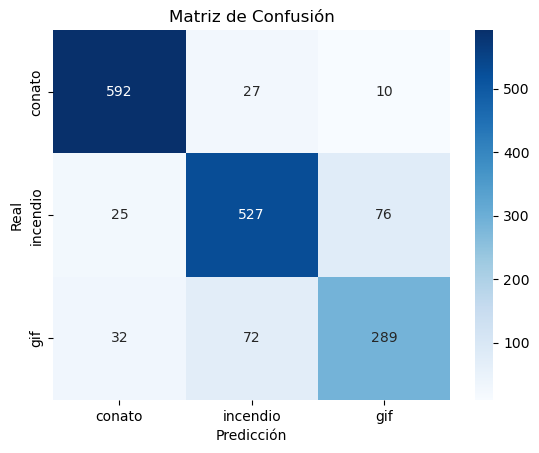

In [79]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas
etiquetas= ['conato', 'incendio', 'gif']

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

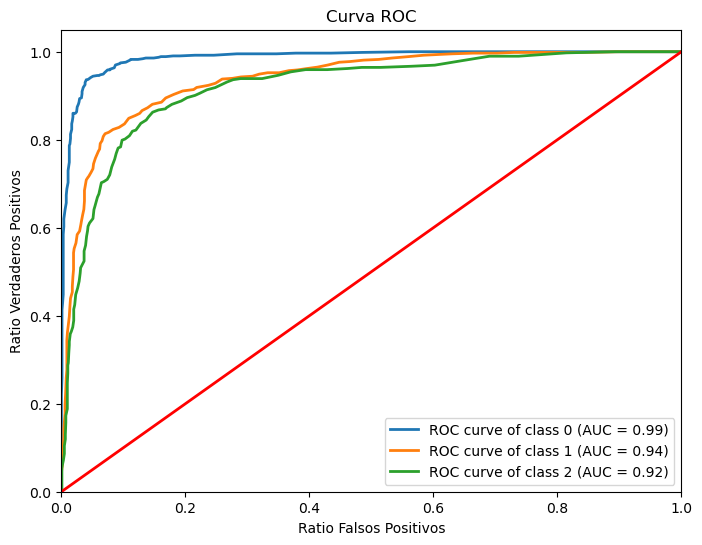

In [80]:
y_pred_prob = rf.predict_proba(X_test)

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva roc y el auc
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el calculo del auc
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

### Intentamos mejorar el Random Forest

In [81]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-12-29 10:58:58,063] A new study created in memory with name: no-name-cb0f04ae-d11f-4867-9bd2-9faf541c3bd4
[I 2024-12-29 10:58:59,312] Trial 0 finished with value: 0.8095652165874619 and parameters: {'n_estimators': 174, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8095652165874619.
[I 2024-12-29 10:59:05,026] Trial 1 finished with value: 0.8168246790053851 and parameters: {'n_estimators': 152, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.8168246790053851.
[I 2024-12-29 10:59:21,632] Trial 2 finished with value: 0.8164099518989761 and parameters: {'n_estimators': 414, 'max_depth': 16, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 1 with value: 0.8168246790053851.
[I 2024-12-29 10:59:25,188] Trial 3 finished with value: 0.8208208208650906 and parameters: {'n_estimators': 417, 'max_depth': 40, 'mi

In [67]:
print(f"Mejor valor objetivo: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")

Mejor valor objetivo: 0.8433353142545209
Mejores hiperparámetros: {'n_estimators': 206, 'max_depth': 39, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [68]:
best_model = RandomForestClassifier(random_state=42, **study.best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       629
           1       0.85      0.84      0.85       628
           2       0.78      0.73      0.76       393

    accuracy                           0.86      1650
   macro avg       0.85      0.84      0.84      1650
weighted avg       0.85      0.86      0.86      1650



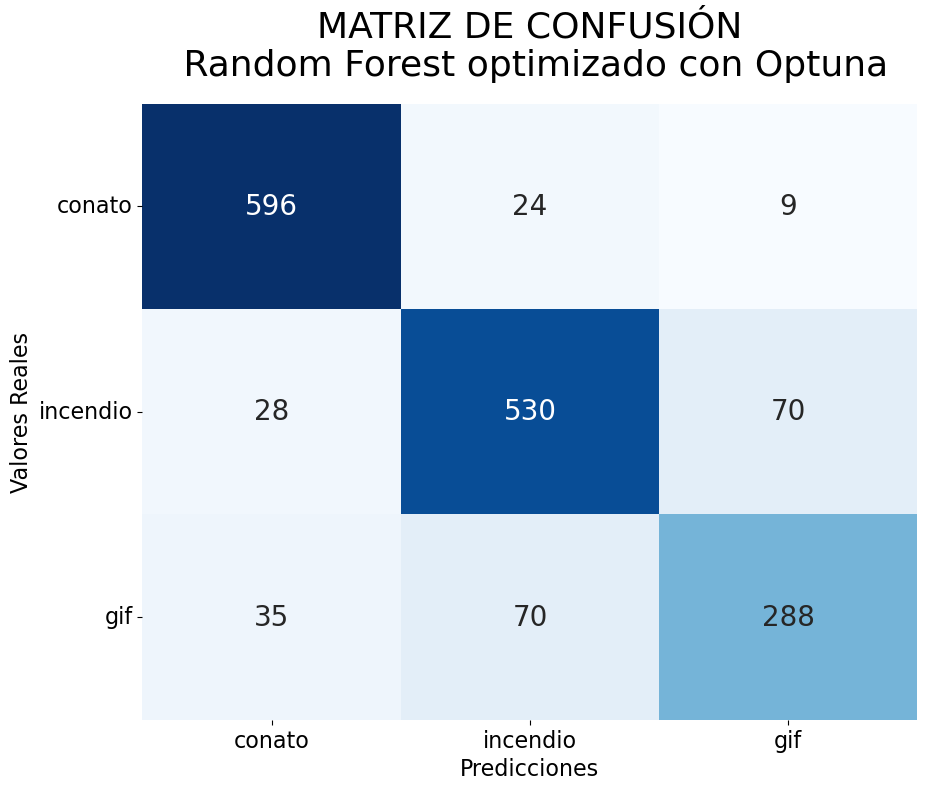

In [69]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n Random Forest optimizado con Optuna", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

In [70]:
import joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [82]:
import joblib

# Cargar el modelo desde el archivo .pkl
best_model = joblib.load('best_random_forest_model.pkl')

# Verificar si se cargó correctamente (opcional)
print("Modelo cargado correctamente:", best_model)

Modelo cargado correctamente: RandomForestClassifier(max_depth=39, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=206, random_state=42)


@inproceedings{akiba2019optuna,
  title={{O}ptuna: A Next-Generation Hyperparameter Optimization Framework},
  author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
  booktitle={The 25th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2623--2631},
  year={2019}
}

#### Fuentes de datos:

1. **AEMET**: Los datos utilizados en este análisis provienen de la **Agencia Estatal de Meteorología (AEMET)**. Los datos están sujetos a las [condiciones de uso de AEMET](https://www.aemet.es/es/portada), y deben ser utilizados con la debida citación.
2. **EGIF**: Los datos utilizados en este análisis provienen de la **Estadística General de Incendios Forestales (EGIF)**, gestionada por el **Ministerio para la Transición Ecológica y el Reto Demográfico (MITECO)**. Los datos deben ser utilizados de acuerdo con las [condiciones de uso de la EGIF](https://www.miteco.gob.es/es/biodiversidad/temas/incendios-forestales/estadisticas-datos.aspx).
3. **NGMEP (Nomenclátor Geográfico de Municipios y Entidades de Población)**: Los datos utilizados en este análisis provienen del **Nomenclátor Geográfico de Municipios y Entidades de Población (NGMEP)**, proporcionado por el **Centro Nacional de Información Geográfica (CNIG)**. Los datos están sujetos a la licencia de [Datos Abiertos del CNIG](https://astronoomia.ign.es/web/ign/portal). Se debe proporcionar citación adecuada al utilizar los datos.
4. **Climate Data Store (CDS)**: Los datos utilizados en este análisis provienen del **Climate Data Store (CDS)**, específicamente del indicador de peligro de incendio **FWI** derivado de proyecciones climáticas para Europa. Los datos están sujetos a la [licencia de uso de CDS](https://cds.climate.copernicus.eu/#!/home), y deben ser utilizados con la debida citación.
5. **INE (Instituto Nacional de Estadística)**: Los datos utilizados en este análisis provienen de las **Series de población por provincia (1900-2001)**, las **principales series de población desde 1998** y del **Código INE**. Los datos están sujetos a las [condiciones de uso del INE](https://www.ine.es/jaxiT3/Datos.htm?t=2865), y deben ser utilizados con la debida citación.